In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape, Concatenate, LSTM, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()

VOCAB_SIZE

1128

In [4]:
tag_data

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [5]:
glove_embeddings=pd.read_csv("../input/Glove.csv",index_col=0)

In [6]:
import re

In [7]:
tag_data["tag"]=tag_data["tag"].apply(lambda x: re.sub("[^a-zA-Z\s]","",x))

In [8]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [9]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE)

In [10]:
tokenizer.fit_on_texts(tag_data["tag"])

In [11]:
word_index=tokenizer.word_index

In [12]:
word_index["imdb"]

663

In [13]:
def create_embedding_matrix(word_index_map,embeddings):
    embedding_matrix=np.zeros((len(word_index_map)+1,embeddings.shape[1]))
    c=0
    for word, index in word_index_map.items():
        embedding_vector=None
        try:
            embedding_vector = embeddings.loc[word]
        except KeyError:
            embedding_vector=None
            c+=1
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    print(f"Could not embed {c} words")
    return embedding_matrix

In [14]:
word_index["frombook"]

241

In [15]:
len(word_index)

1155

In [16]:
glove_embeddings.loc["user"]

0    -0.53900
1     0.03310
2     0.52300
3     0.02669
4     0.61960
       ...   
95    0.02710
96   -0.01747
97   -0.87800
98    0.53800
99   -0.29610
Name: user, Length: 100, dtype: float64

In [17]:
word_index

{'best': 1,
 'oscar': 2,
 'good': 3,
 'war': 4,
 'movie': 5,
 'bad': 6,
 'nudity': 7,
 'based': 8,
 'on': 9,
 'comedy': 10,
 'the': 11,
 'plot': 12,
 'great': 13,
 's': 14,
 'ending': 15,
 'music': 16,
 'funny': 17,
 'world': 18,
 'a': 19,
 'book': 20,
 'story': 21,
 'dialogue': 22,
 'action': 23,
 'comic': 24,
 'of': 25,
 'film': 26,
 'dark': 27,
 'fantasy': 28,
 'family': 29,
 'effects': 30,
 'relationship': 31,
 'new': 32,
 'alternate': 33,
 'history': 34,
 'cinematography': 35,
 'soundtrack': 36,
 'acting': 37,
 'science': 38,
 'sequel': 39,
 'video': 40,
 'game': 41,
 'and': 42,
 'drama': 43,
 'cult': 44,
 'as': 45,
 'scifi': 46,
 'life': 47,
 'love': 48,
 'notable': 49,
 'original': 50,
 'space': 51,
 'time': 52,
 'adaptation': 53,
 'adapted': 54,
 'afi': 55,
 'reality': 56,
 'civil': 57,
 'animated': 58,
 'animation': 59,
 'cgi': 60,
 'script': 61,
 'true': 62,
 'tv': 63,
 'better': 64,
 'school': 65,
 'brothers': 66,
 'business': 67,
 'abuse': 68,
 'classic': 69,
 'america': 70

In [18]:
embedding_matrix=create_embedding_matrix(word_index,glove_embeddings)

Could not embed 25 words


In [19]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [20]:
VOCABULARY=tag_data.tag.unique().tolist()
len(VOCABULARY)

1114

In [21]:
SEQUENCE_LENGTH=50

In [22]:
master_data=pd.read_csv("../data/Master_dataset.csv")

In [23]:
NUMBER_OF_MOVIES=master_data.movieId.nunique()
NUMBER_OF_USERS=master_data.userId.nunique()

In [24]:
def create_model(embedding_size=32):
    user_tag=Input(name="user_tags",shape=[SEQUENCE_LENGTH])
    movie_tag=Input(name="movie_tags",shape=[SEQUENCE_LENGTH])
    
    # user_tag_vectorized = TextVectorization(
    # standardize="strip_punctuation",
    # max_tokens=VOCAB_SIZE,
    # output_mode='int',
    # output_sequence_length=SEQUENCE_LENGTH,
    # vocabulary=VOCABULARY)(user_tag)
    
    # movie_tag_vectorized = TextVectorization(
    # standardize="strip_punctuation",
    # max_tokens=VOCAB_SIZE,
    # output_mode='int',
    # output_sequence_length=SEQUENCE_LENGTH,
    # vocabulary=VOCABULARY)(movie_tag)
    
    combined_tags=Concatenate(axis=-1)([user_tag,movie_tag])
    
    
    embeddings = Embedding(name = 'embedding',input_dim = len(word_index)+1, output_dim = glove_embeddings.shape[1], trainable=False)(combined_tags)
    # movie_embedding= Embedding(name = 'movie_embedding',input_dim = NUMBER_OF_MOVIES, output_dim = embedding_size)(movie_tag_vectorized)
    
    # merged = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, movie_embedding])
    
    # merged = Reshape(target_shape = [2500])(merged)
    
    # merged=Dense(2500, activation="relu")(merged)
    
    # merged=Dense(1500, activation="relu")(merged)
    
    # merged=Dense(500, activation="relu")(merged)
    
    X = LSTM(128, return_sequences=True)(embeddings)

    X = Dropout(0.6)(X)

    X = LSTM(128, return_sequences=True)(X)

    X = Dropout(0.6)(X)

    X = LSTM(128)(X)

    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[user_tag,movie_tag], outputs=X)
    model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [25]:
model=create_model()

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 100)          0           ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     115600      ['concatenate[0][0]']        

In [27]:
def split_x_and_y(data,label="rating"):
    X_user=data["user_tags"]
    X_movie=data["tag"]
    y=data[label]
    X_user_indices = tokenizer.texts_to_sequences(X_user)
    X_movie_indices = tokenizer.texts_to_sequences(X_movie)
    X_user_indices = pad_sequences(X_user_indices, maxlen=50, padding='post')
    X_movie_indices = pad_sequences(X_movie_indices, maxlen=50, padding='post')
    return X_user_indices,X_movie_indices, y

In [28]:
test=pd.read_csv("../input/test_user_item.csv")
train=pd.read_csv("../input/train_user_item.csv")
validation=pd.read_csv("../input/validation_user_item.csv")

In [29]:
train

,user_tags,tag,rating
0,sexualized violence gay science fiction brothe...,high school teen original fun movie bad plot t...,3
1,film noir predictable sci fi twist ending stup...,gritty crime original violent neonoir violence...,5
2,biography great movie mentor musical oscar bes...,awesome soundtrack nostalgia california s teen...,5
3,weirdadolescence dramatic controversial gangst...,social commentary crime violent amazing cinema...,4
4,vengeance original mentor romantic money con m...,musical powerful ending music emotional melanc...,6
...,...,...,...
402465,social commentary original mentor futuristic f...,mob crime great movie violent violence gangste...,5
402466,biography coen bros predictable stupidity clas...,world politics complex francis ford copolla me...,4
402467,biography weirdcensorship dreamlike stupid as ...,future space space opera scifi futuristic robo...,4
402468,greed runaway great ending insanity prison eni...,noir crime greed crime gone awry caper black a...,6


In [30]:
value_counts=train["rating"].value_counts().to_dict()

In [31]:
value_counts

{4: 140029, 5: 133038, 3: 57571, 6: 41784, 2: 21999, 1: 8049}

In [32]:
highest_frequency=max(value_counts.values())

In [33]:
class_weights={k:(highest_frequency/v) for k,v in value_counts.items()}

In [34]:
class_weights

{4: 1.0,
 5: 1.0525488958042064,
 3: 2.4322836150145037,
 6: 3.3512588550641396,
 2: 6.365243874721578,
 1: 17.39706795875264}

In [35]:
train_user, train_movie, train_y=split_x_and_y(train)
test_user, test_movie, test_y=split_x_and_y(test)

validation_user, validation_movie, validation_y=split_x_and_y(validation)

KeyboardInterrupt: 

In [ ]:
train

,user_tags,tag,rating
0,brutalitychasecheerleadingcorruptiondramagreed...,cinematographycreepydarkeeriefrancis ford copo...,4
1,salcoholismbleakcharacter studydepressiondownb...,art housecorruptiondetectivedialogueentirely d...,4
2,adulterybetrayalbrutalitycomplexdialoguegangst...,bleakdarkdepressiondrinkingdrug abusedrug addi...,4
3,britishchaseconspiracycorruptiondramakidnappin...,capercoolcrimedialoguegangstergangstersgreatgr...,4
4,adapted frombookbased on a bookbased on bookbo...,franchisegood sequelhorriblehorrorislandorigin...,2
...,...,...,...
402465,creepycult filmdoctorsgood sequelgothichorrori...,betrayalespionagegermanyholocaustisraeljewsmal...,4
402466,based on a bookcensorshipfight scenesgood soun...,actionaction packedadventurearchaeologybetter ...,6
402467,biographybusinesschildhoodcomputersgreedhistor...,excellent scriptgreat actinghannibal lecterimd...,5
402468,authorneil gaimanbiographydocumentarydrinkingd...,comedyfunnygreatgreat moviehilarioushumorousli...,6


In [ ]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=1024,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights
    epochs=1)

394/394 [==============================] - 68s 151ms/step - loss: nan - accuracy: 2.4847e-05 - val_loss: nan - val_accuracy: 0.0000e+00


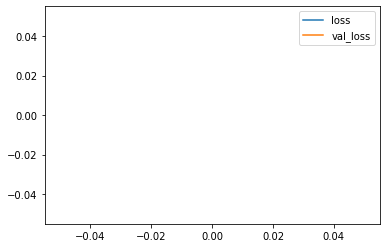

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

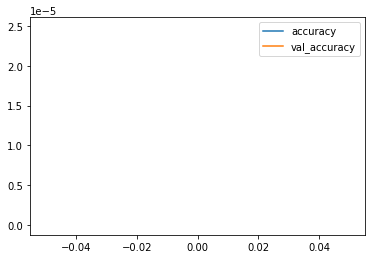

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])

In [ ]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

303/303 [==============================] - 13s 42ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [ ]:
y_pred=np.argmax(model.predict([test_user, test_movie],batch_size=1024),axis=1)

303/303 [==============================] - 13s 41ms/step


In [ ]:
train_y.value_counts()

4    140001
5    133057
3     57581
6     41550
2     22116
1      8165
Name: rating, dtype: int64

In [ ]:
test_y.value_counts()

4    107888
5    102524
3     44184
6     31981
2     16836
1      6179
Name: rating, dtype: int64

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
test_y

0         4
1         4
2         4
3         3
4         4
         ..
309587    2
309588    4
309589    5
309590    5
309591    3
Name: rating, Length: 309592, dtype: int64

In [ ]:
print(classification_report(y_pred=y_pred,y_true=test_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    6179.0
           2       0.00      0.00      0.00   16836.0
           3       0.00      0.00      0.00   44184.0
           4       0.00      0.00      0.00  107888.0
           5       0.00      0.00      0.00  102524.0
           6       0.00      0.00      0.00   31981.0

    accuracy                           0.00  309592.0
   macro avg       0.00      0.00      0.00  309592.0
weighted avg       0.00      0.00      0.00  309592.0



c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\minic

In [ ]:
user_layer = model.get_layer('user_embedding')
user_weights = user_layer.get_weights()[0]

ValueError: No such layer: user_embedding. Existing layers are: ['user_tags', 'movie_tags', 'concatenate_1', 'embedding', 'lstm_3', 'dropout_2', 'lstm_4', 'dropout_3', 'lstm_5', 'dense_1'].

In [ ]:
user_weights.shape

(1551, 16)

In [ ]:
user_metadata=pd.read_csv("../data/user_metadata.csv")

In [ ]:
user_metadata

,userId,user_tags
0,1,bloody|crime gone awry|dark humor|gangsters|go...
1,2,animated|animation|cartoon|childhood|children|...
2,3,children|dark|dark fantasy|dreamlike|dreams|fu...
3,4,action|action packed|chase|explosions|good act...
4,5,comedy|detective|dumb|funniest movies|funny|fu...
...,...,...
1546,19156,chase|classic car|desert|fight scenes|franchis...
1547,19247,childhood|culture clash|drama|dramatic|family|...
1548,19744,action|action packed|cool|fight scenes|fightin...
1549,20055,alter ego|brutality|chase|corruption|gunfight|...


In [ ]:
user_embeddings=pd.DataFrame(user_weights)

In [ ]:
user_embeddings.index=user_metadata["userId"]

In [ ]:
user_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
userId,,,,,,,,,,,,,,,,
1,0.049053,0.012586,0.042760,0.035275,-0.018311,0.027319,0.012470,0.028732,0.046874,-0.032767,-0.011572,0.002235,-0.007446,0.003099,0.004208,-0.029923
2,0.064489,0.007500,-0.057657,-0.025601,-0.006158,-0.027823,-0.042360,-0.022607,0.008364,-0.005637,-0.015787,0.029946,0.026403,0.000526,0.051550,-0.004919
3,0.031875,-0.055906,-0.040483,-0.001891,0.019767,-0.021758,-0.015223,0.025881,0.045808,-0.046808,0.080722,0.008536,0.062324,-0.043263,-0.018091,0.030492
4,-0.033347,-0.023923,0.046837,-0.049534,0.020543,-0.040632,-0.047492,0.021126,-0.028792,-0.048989,0.041527,-0.027841,0.024530,-0.033085,0.038022,-0.007779
5,-0.000439,0.028392,0.007752,-0.041865,0.022761,0.000196,0.000815,0.026624,0.003920,-0.008142,-0.036802,0.040262,-0.026110,0.042429,-0.036349,0.004190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19156,-0.046939,0.047684,-0.003289,-0.024537,0.001372,0.012914,-0.039672,-0.019049,-0.016877,0.040283,-0.045703,-0.008710,0.004924,-0.003992,0.039954,-0.011995
19247,0.030767,-0.036782,-0.030245,0.024984,-0.045024,-0.030471,-0.032704,-0.017660,0.010668,-0.032415,-0.046241,-0.013265,0.044551,-0.037708,0.032256,-0.002962
19744,-0.005040,0.040255,0.046589,-0.029141,0.037740,-0.007180,0.039085,-0.025089,0.040988,-0.023773,0.022856,0.019644,0.044328,0.030371,0.013475,0.046434


In [ ]:
movie_layer = model.get_layer('movie_embedding')
movie_weights = movie_layer.get_weights()[0]

In [ ]:
movie_metadata=pd.read_csv("../data/movie_metadata.csv")

In [ ]:
movie_metadata

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animated|animation|cartoon|childhood|children|...
1,2,Jumanji (1995),Adventure|Children|Fantasy,adventure|animals|based on a book|big budget|c...
2,3,Grumpier Old Men (1995),Comedy|Romance,comedy|crappy sequel|destiny|fun movie|good|go...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,adultery|chick flick|divorce|drinking|feel-goo...
4,5,Father of the Bride Part II (1995),Comedy,comedy|family|father daughter relationship|fee...
...,...,...,...,...
13811,205072,Zombieland: Double Tap (2019),Action|Comedy|Horror,based on book|based on true story|clever|dumb ...
13812,205076,Downton Abbey (2019),Drama,aardman studios|brutality|clever|feel-good|gir...
13813,205383,El Camino: A Breaking Bad Movie (2019),Crime|Drama|Thriller,chase|clever|corruption|crime|drama|good sound...
13814,205425,Dave Chappelle: Sticks & Stones (2019),Comedy,clever|comedy|complex|cult classic|dialogue|dr...


In [ ]:
movie_embeddings=pd.DataFrame(movie_weights)

In [ ]:
movie_embeddings.index=movie_metadata["movieId"]

In [ ]:
movie_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
movieId,,,,,,,,,,,,,,,,
1,0.003437,0.055751,-0.012489,0.026808,-0.027864,-0.057591,-0.041426,-0.018184,-0.006472,-0.007097,-0.039785,0.034548,-0.057245,0.081165,-0.034283,-0.043463
2,0.042864,-0.042259,-0.015663,-0.007935,0.007611,-0.043563,-0.002566,0.040773,0.025241,-0.014979,0.039326,0.040333,0.026736,0.035545,-0.074613,0.008969
3,0.006988,-0.096399,0.016839,0.014217,0.045823,0.043605,-0.027642,-0.009923,0.056259,-0.006837,0.045438,-0.001388,0.051768,0.029557,-0.012670,0.023724
4,-0.001470,0.016399,0.029901,-0.005236,-0.049207,0.004207,-0.010726,-0.018834,-0.012509,0.021377,-0.028011,0.014415,0.018715,-0.007692,-0.041538,-0.025772
5,-0.015494,0.024464,0.037852,0.031572,-0.008000,-0.029802,-0.016331,-0.027752,-0.034031,0.009654,-0.044221,0.003998,0.011291,0.022377,0.034840,0.001319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205072,-0.025819,-0.008140,0.005033,-0.003035,0.041047,-0.006903,0.026847,0.030742,0.048011,-0.003133,-0.042003,0.032004,0.001799,-0.035056,0.044188,-0.048996
205076,0.017247,-0.026777,0.002320,-0.045249,-0.039453,0.040265,-0.041056,-0.025936,0.009327,-0.030110,-0.016593,-0.006498,-0.040246,-0.017034,-0.000700,-0.019508
205383,0.019961,0.007115,-0.049529,-0.021162,0.048764,-0.012678,0.014460,-0.000342,0.026879,0.006778,-0.023536,0.039764,-0.012091,-0.023649,-0.002290,-0.044816


In [ ]:
movie_weights.shape

(13816, 16)